In [235]:
using LinearAlgebra
using Distributions: Bernoulli
using Plots
pyplot()
using SpecialFunctions: erf

# CDF of 1D Gaussian
#ϕ(x,μ) = 0.5( 1. + erf((x-μ)))
ϕ(μ,σ) = 0.5( 1. + (erf( μ / (σ^2 * √(2)) )))
#ϕ(μ,σ) = 0.5( 1. + (erf( μ / (√(2)) )))

# Binary entropy. Epsilons for stability
h(p) = -p*log(p+eps()) - (1-p)*log(1-p + eps())

# Approximate conditional entropy term
C = √((π*log(2)/2))
H(μ,σ) = (C / √(σ + C^2))* exp(-0.5 * (μ^2 / (σ^2 + C^2)))

# BALD objective
BALD(μ,σ) = h(ϕ(μ,σ)) - H(μ,σ)

# KL between Bernoullis, epsilons for stability.
KL(p,q) = p * log( eps() + p/q ) + (1-p) * log(eps() +  (1-p)/(1-q))


function kernel(x1,x2,σ,l)
    σ^2 * exp.(-(x1 .- x2').^2 ./ (2*l^2))
end


function pref_kernel(u,v,σ,l)
    kernel(u[:,1],v[:,1],σ,l) + kernel(u[:,2],v[:,2],σ,l) - kernel(u[:,1],v[:,2],σ,l) - kernel(u[:,2],v[:,1],σ,l)
end


pref_kernel (generic function with 1 method)

In [236]:
# Compares first arg to second
function response(x,y)
    p1 = (5-x)^2
    p2 = (5-y)^2
    if p1 == p2
	return Float64(rand(Bernoulli(0.5))) # Somehow crashes if not recast to float
    elseif p1 < p2
	return 1.
    else
	return 0.
    end
    #Float64(rand(Bernoulli(p1-p2))) # Somehow crashes if not recast to float
end

function predict(x1,x2,y,σ,l)
    n = size(x1,1)
    Σ_11 = pref_kernel(x1, x1, σ, l) + I(n)*0.5 # standard normal observation noise
    Σ_22 = pref_kernel(x2, x2, σ, l)
    Σ_12 = pref_kernel(x1, x2, σ, l)

    # Average out small numerical instabilities.
    # Usually it's on the order 1e-16 or smaller but it breaks the cholesky
    Σ_11 = (Σ_11 + Σ_11')/2
    chol11 = cholesky(Σ_11)

    # Rasmussen tricks for stability and efficiency
    solved = chol11.U\(chol11.L\Σ_12)

    Σ_pred= Σ_22 - solved' * Σ_12
    # Fix numerics again.
    Σ_pred = (Σ_pred + Σ_pred')/2 #+ I(size(Σ_pred,1)) * 1e-6

    μ_pred = solved' * y

    return μ_pred, Σ_pred
end


function choose_point(x1,y1,x2,σ,l)
    μ_pred,Σ_pred =predict(x1,x2,y,σ,l)
    # Extra entropy at the end makes it EFE
    -BALD(μ_pred[1],Σ_pred[1]) + KL(ϕ(μ_pred[1],Σ_pred[1]),1-eps()) + h(ϕ(μ_pred[1],Σ_pred[1]))
end


choose_point (generic function with 1 method)

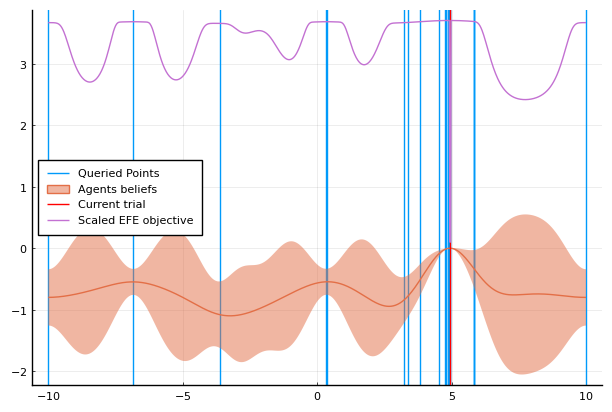

Animation("/tmp/jl_6YXiwm", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png", "000011.png", "000012.png", "000013.png", "000014.png", "000015.png", "000016.png", "000017.png", "000018.png", "000019.png", "000020.png"])

In [237]:
temp = []
xs = []
ids = []

x1 = -2. .+ randn(1,2)
x_t = x1[1]
y = [response(x1[1],x1[2])]




anim = @animate for t ∈ 1:20
    σ = 1.
    l = 1

    # There's probably a better solution than gridsearch
    gridman =LinRange(-10,10,1000)

    bro = []
    dudebro = []
    for x_new in gridman
        if x_new != x_t
            append!(bro,choose_point(x1,y,vcat(x_new,x_t)',σ,l))
            append!(dudebro,x_new)
        end
    end
    #idx = argmin([choose_point(x1,y,vcat(x_new,x_t)',σ,l) for x_new in gridman if x_new != x_t])
    idx = argmin(bro)
    append!(ids,idx)
    
    # move to the new point
    #x_new = gridman[idx]
    x_new = dudebro[idx]
    
    # Get a response and store it
    append!(y,response(x_new,x_t))

    # Update data set with new observation
    x1 = vcat(x1,[x_new,x_t]')

    bob = [choose_point(x1,y,vcat(x_new,x_t)',σ,l) for x_new in gridman]

    estimated = [predict(x1,vcat(x_new,x_t)',y,σ,l) for x_new in gridman]
    Σs = [x[2][1] for x in estimated]
    μs = [x[1][1] for x in estimated]

    vline(x1[:,1],label="Queried Points")
    plot!(gridman,μs,ribbon=Σs,label="Agents beliefs")
    vline!([gridman[argmin(bob)]], label="Current trial",color="red")
    plot!(gridman,bob ./ 10 ,label="Scaled EFE objective")

       # Reset for next round
    x_t = x_new
end



┌ Info: Saved animation to 
│   fn = /home/mkoudahl/biaslab/repos/efe_gp/anim.gif
└ @ Plots /home/mkoudahl/.config/julia/packages/Plots/lmp2A/src/animation.jl:104


Plots.AnimatedGif("/home/mkoudahl/biaslab/repos/efe_gp/anim.gif")
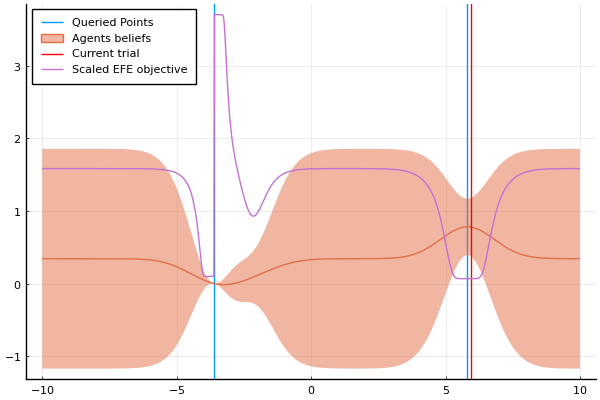

In [238]:
gif(anim, "anim.gif", fps = 2)
